<a href="https://colab.research.google.com/github/sunnykart11/AIFFEL_quest_cr/blob/main/MainQuest/Quest02/MainQuest02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. 개요  

*   목표 : Kaggle 사이트에 올라와 있는 포켓몬 데이터셋을 활용하여 포켓몬의 이름, 속성, 스탯 값만을 가지고 전설의 포켓몬인지 아닌지를 구별해내는 모델을 개발할 수 있다.
*   모델 학습 시작 전, 모든 컬럼에 대해 다양한 방법으로 EDA(탐색적 데이터 분석, Exploratory Data Analysis)을 진행한다.
*   모델 학습에 넣기 위해 데이터 전처리를 진행한다. (본 모델에서는 원-핫 인코딩 진행)
*   모델 학습 성공 여부를 판단하기 위해, 전처리를 수행하기 전 기본 데이터셋을 Decision Tree 모델로 학습시키고 결과를 얻는다.
*   전처리가 끝난 데이터셋을 Decision Tree 모델로 학습시킨 후 그 결과를 기본 데이터셋의 학습 결과와 비교한다.
*   Deicision Tree 이외의 분류 모델을 이용하여 학습시킨 후 그 결과를 비교한다.

# 2. 과정


In [9]:
# 쓸 라이브러리들 한 번에 불러오기
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
%matplotlib inline
%config InlineBackend.figure_format = 'retina'


### 1. 기본 모델이 동작하는 코드

In [11]:
#1-1. 데이터 불러오기
import kagglehub

# Download latest version
path = kagglehub.dataset_download("abcsds/pokemon")

# 캐글에서 가져온 pokemon 폴더 내 파일 리스트 확인
# print(os.listdir(path))      #Pokemon.csv 파일이 있는 것을 확인
csv_path = os.path.join(path, "Pokemon.csv")

# CSV 파일 읽기
original_data = pd.read_csv(csv_path)

# 데이터 확인
print(pokemon.shape)
print(original_data.head())  #출력 결과 800행과 13열 확인, Legendary는 bool

# 원본 데이터는 놔두고 새로 복사해서 작업 진행할 예정
pokemon = original_data.copy()

(800, 13)
   #                   Name Type 1  Type 2  Total  HP  Attack  Defense  \
0  1              Bulbasaur  Grass  Poison    318  45      49       49   
1  2                Ivysaur  Grass  Poison    405  60      62       63   
2  3               Venusaur  Grass  Poison    525  80      82       83   
3  3  VenusaurMega Venusaur  Grass  Poison    625  80     100      123   
4  4             Charmander   Fire     NaN    309  39      52       43   

   Sp. Atk  Sp. Def  Speed  Generation  Legendary  
0       65       65     45           1      False  
1       80       80     60           1      False  
2      100      100     80           1      False  
3      122      120     80           1      False  
4       60       50     65           1      False  


In [15]:
#1-2. 문자열 데이터와 타겟 데이터 제외하기
features = ['Total', 'HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed', 'Generation']
target = 'Legendary'
    #1-1 출력을 통해 #, Name, Type1, Type2 데이터를 제외해야 함을 확인, target 데이터인 Legendary도 제외
X = original_data[features]      #features 컬럼에 해당하는 데이터를 변수 X에 저장
y = original_data[target]      #target 컬럼의 데이터를 변수 y에 저장
X.head()                  #변수 X 확인하기

,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation
0,318,45,49,49,65,65,45,1
1,405,60,62,63,80,80,60,1
2,525,80,82,83,100,100,80,1
3,625,80,100,123,122,120,80,1
4,309,39,52,43,60,50,65,1


In [16]:
#1-3. 학습데이터와 테스트 데이터를 8:2 비율로 나누기
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=15)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(640, 8) (640,)
(160, 8) (160,)


In [18]:
#1-4. decision tree로 학습시키기
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier(random_state=25)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [22]:
#1-5. 학습 결과 보기
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.97      0.98      0.97       147
        True       0.73      0.62      0.67        13

    accuracy                           0.95       160
   macro avg       0.85      0.80      0.82       160
weighted avg       0.95      0.95      0.95       160



accuracy는 0.95로 높은 편이지만 recall이 0.62로 낮음.  
즉, 전설의 포켓몬을 일반 포켓몬이라고 잘못 판단한 경우가 많다는 것을 의미.   
정확도가 높게 나온 이유에 대해 이어지는 '2. 데이터 전처리' 에서 알아보자.
* accuracy = TP+TN/TP+TN+FP+FN  
* recall = TP/TP+FN

### 2. 데이터 전처리(복사해둔 pokemon 데이터셋으로 진행)

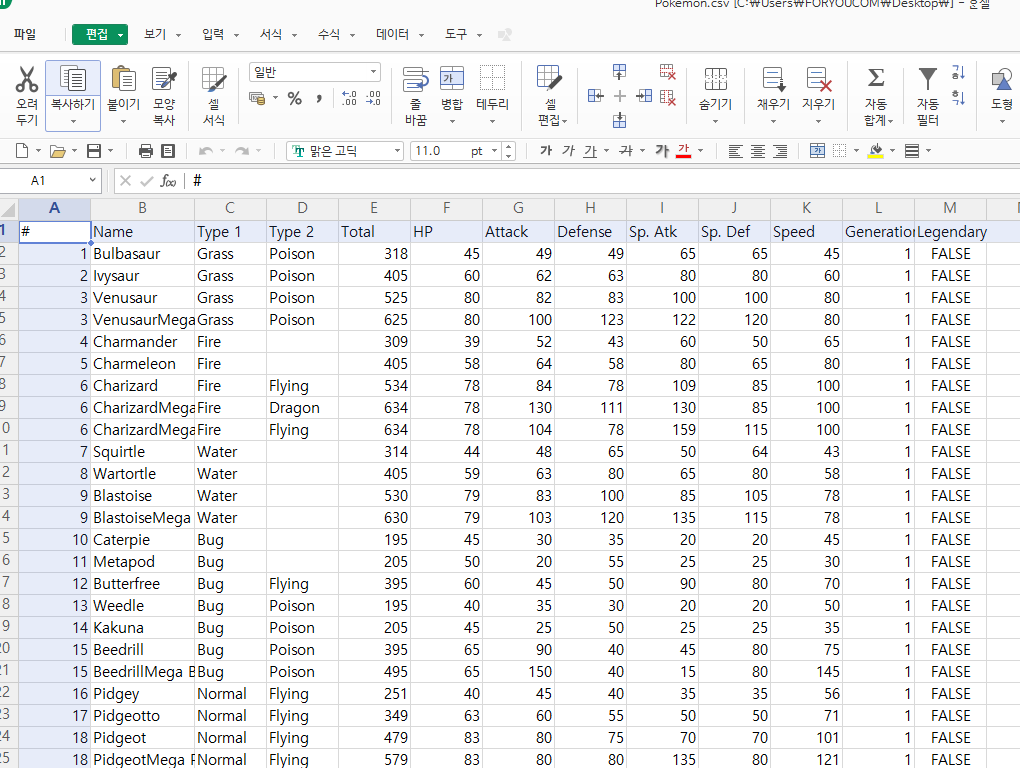  
원본 데이터를 육안으로 봤을 때 '#' 컬럼에 중복값이 존재하고, 'Type2' 컬럼에 결측치가 있음을 확인

In [24]:
#2-1. 결측치 확인
pokemon.isnull().sum()         #type2 컬럼에만 386개의 결측치 확인

,0
#,0
Name,0
Type 1,0
Type 2,386
Total,0
HP,0
Attack,0
Defense,0
Sp. Atk,0
Sp. Def,0


In [26]:
#2-2. '#'컬럼 살펴보기
len(set(pokemon['#']))   #전체 포켓몬이 800마리인데 '#'의 개수가 721이라는 것은
                          #같은 '#' 값을 가지는 포켓몬이 있다는 것

#예시로 #6의 포켓몬 확인해보기
pokemon[pokemon['#']==6]

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
6,6,Charizard,Fire,Flying,534,78,84,78,109,85,100,1,False
7,6,CharizardMega Charizard X,Fire,Dragon,634,78,130,111,130,85,100,1,False
8,6,CharizardMega Charizard Y,Fire,Flying,634,78,104,78,159,115,100,1,False


6인 포켓몬을 확인한 결과 Charizard, CharizardMega Charizard X, CharizardMega Charizard Y 세 개로 나뉘는 것을 확인.  
리자몽에서 시작해서 진화한 버전들임을 추측 가능.  
포켓몬들의 이름은 unique한지 확인해야할 필요성이 생김.

In [27]:
#2-3. Name 컬럼 살펴보기
len(set(pokemon['Name']))       #800으로 중복값 없음을 확인

800

In [29]:
#2-4. Type1과 Type2의 종류는 각각 몇 가지인지 확인
len(set(pokemon['Type 1'])), len(set(pokemon['Type 2']))

(18, 19)

In [31]:
#2-5. Type1과 Type2의 차집합 확인
set(pokemon['Type 2'])-set(pokemon['Type 1'])

{nan}

즉 결측치를 제외한 나머지 18가지 속성은 Type1과 Type2에 모두 같은 세트의 데이터가 들어가 있음을 알 수 있다.  
type이 하나만 있다면 type2는 NaN값일 것이다.
type2가 NaN인 포켓몬의 수를 알 필요성이 생긴다.

In [32]:
#2-6. Type2가 결측치인 데이터의 개수 확인
pokemon['Type 2'].isna().sum()

386

확인 결과 386마리는 속성을 하나만 가짐.  

포켓몬들의 속성 분포를 확인해야 할 필요성이 생긴다.  

일반 포켓몬과 전설의 포켓몬으로 분리해서 알아보겠다.

In [23]:
#2-7. 레전드 포켓몬과 일반 포켓몬을 분리 저장
legendary = pokemon[pokemon['Legendary']==True].reset_index(drop=True)
ordinary = pokemon[pokemon['Legendary']==False].reset_index(drop=True)
legendary.head()   #잘 되었나 확인

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,144,Articuno,Ice,Flying,580,90,85,100,95,125,85,1,True
1,145,Zapdos,Electric,Flying,580,90,90,85,125,90,100,1,True
2,146,Moltres,Fire,Flying,580,90,100,90,125,85,90,1,True
3,150,Mewtwo,Psychic,NaN,680,106,110,90,154,90,130,1,True
4,150,MewtwoMega Mewtwo X,Psychic,Fighting,780,106,190,100,154,100,130,1,True


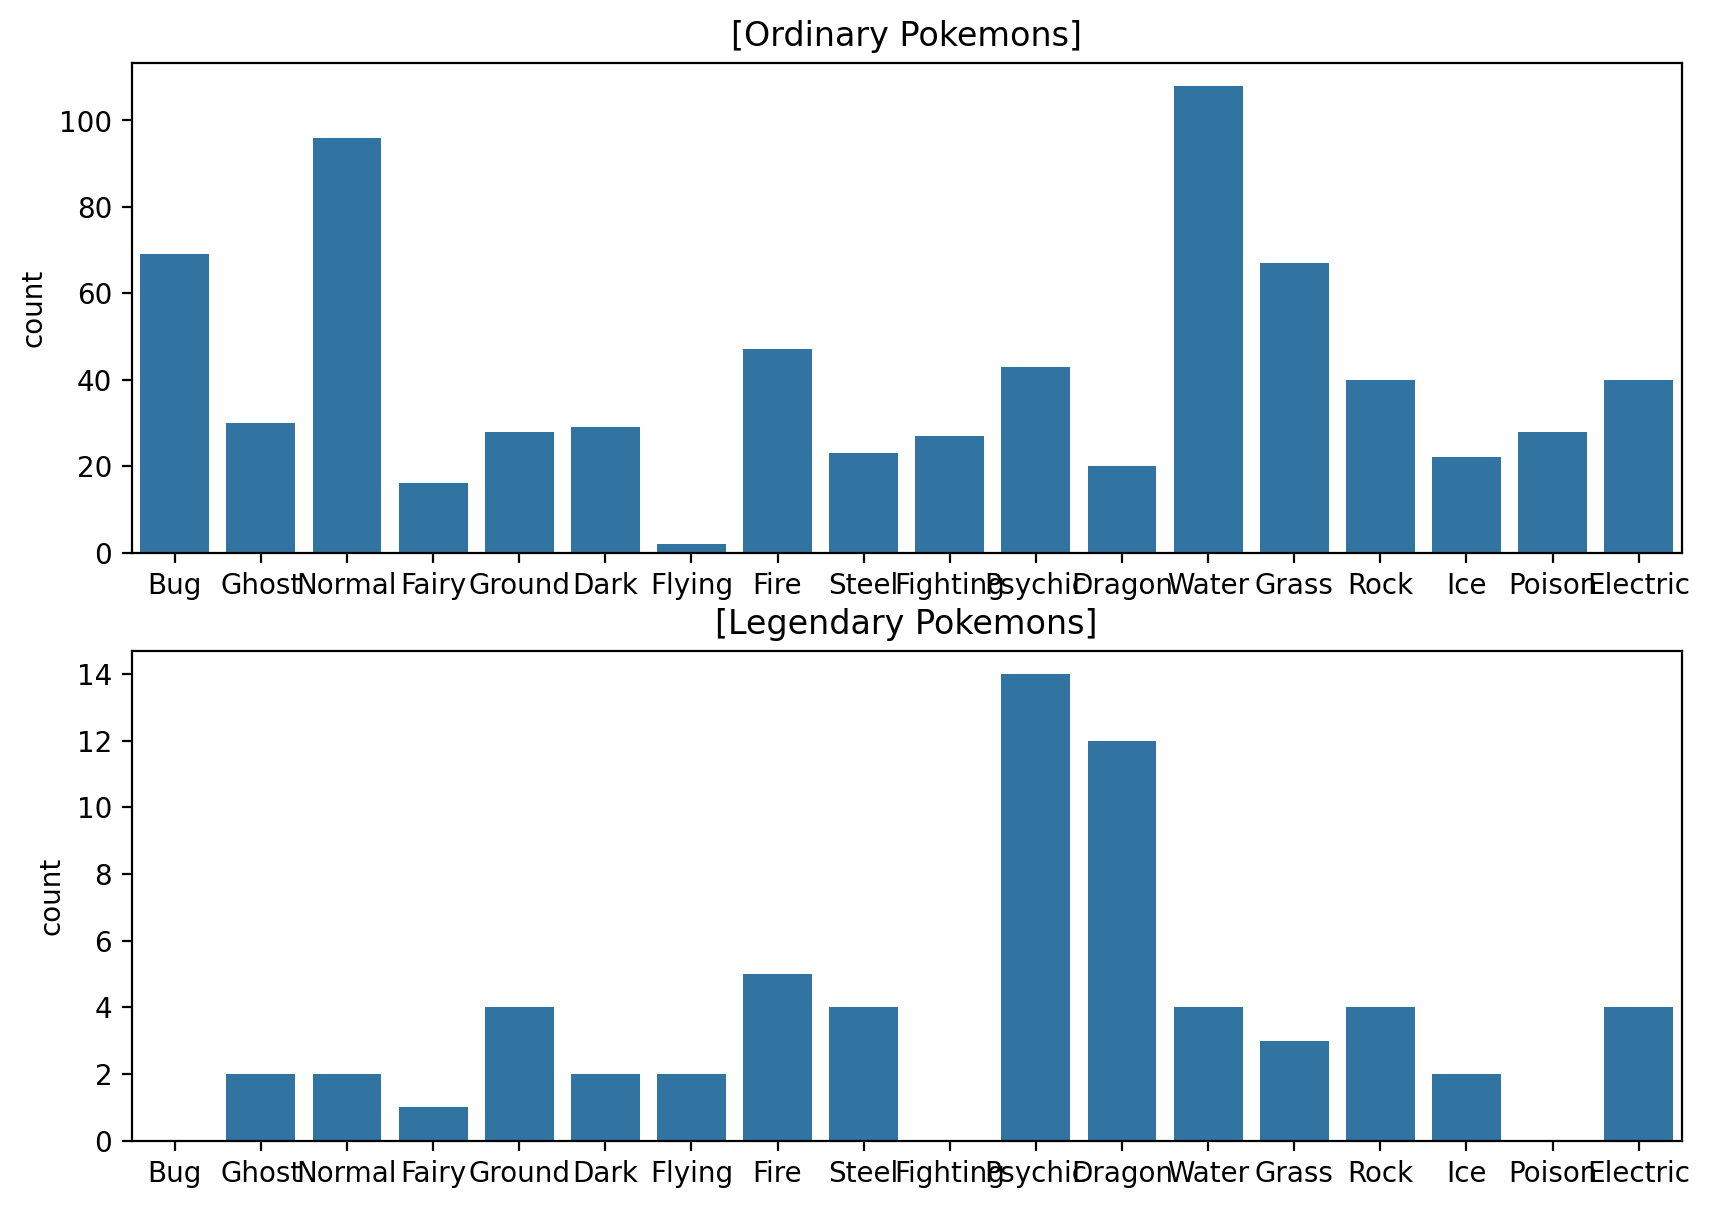

In [35]:
#2-8. 일반 포켓몬과 레전드 포켓몬의 type1 분포 알아보기
types = list(set(pokemon['Type 1']))    #앞서 2-5에서 결측치를 제외한 나머지 값들은 type1과 type2가 동일함을 확인.
                                         #모든 type을 변수 types에 저장
plt.figure(figsize=(10,7))
plt.subplot(211)
sns.countplot(data=ordinary, x='Type 1', order=types).set_xlabel('')
plt.title('[Ordinary Pokemons]')

plt.subplot(212)
sns.countplot(data=legendary, x="Type 1", order=types).set_xlabel('')
plt.title("[Legendary Pokemons]")

plt.show()
#일반 포켓몬에는 Normal, Water이, 전설의 포켓몬에는 Dragon, Psychic 속성이 가장 많음

In [36]:
#2-9. 피벗테이블로 각 속성에 속하는 Legendary 포켓몬의 퍼센트 확인
pd.pivot_table(pokemon, index="Type 1", values="Legendary").sort_values(by=["Legendary"], ascending=False)
  #Flying 속성을 가진 포켓몬의 50프로는 전설의 포켓몬임

,Legendary
Type 1,
Flying,0.500000
Dragon,0.375000
Psychic,0.245614
Steel,0.148148
Ground,0.125000
Fire,0.096154
Electric,0.090909
Rock,0.090909
Ice,0.083333


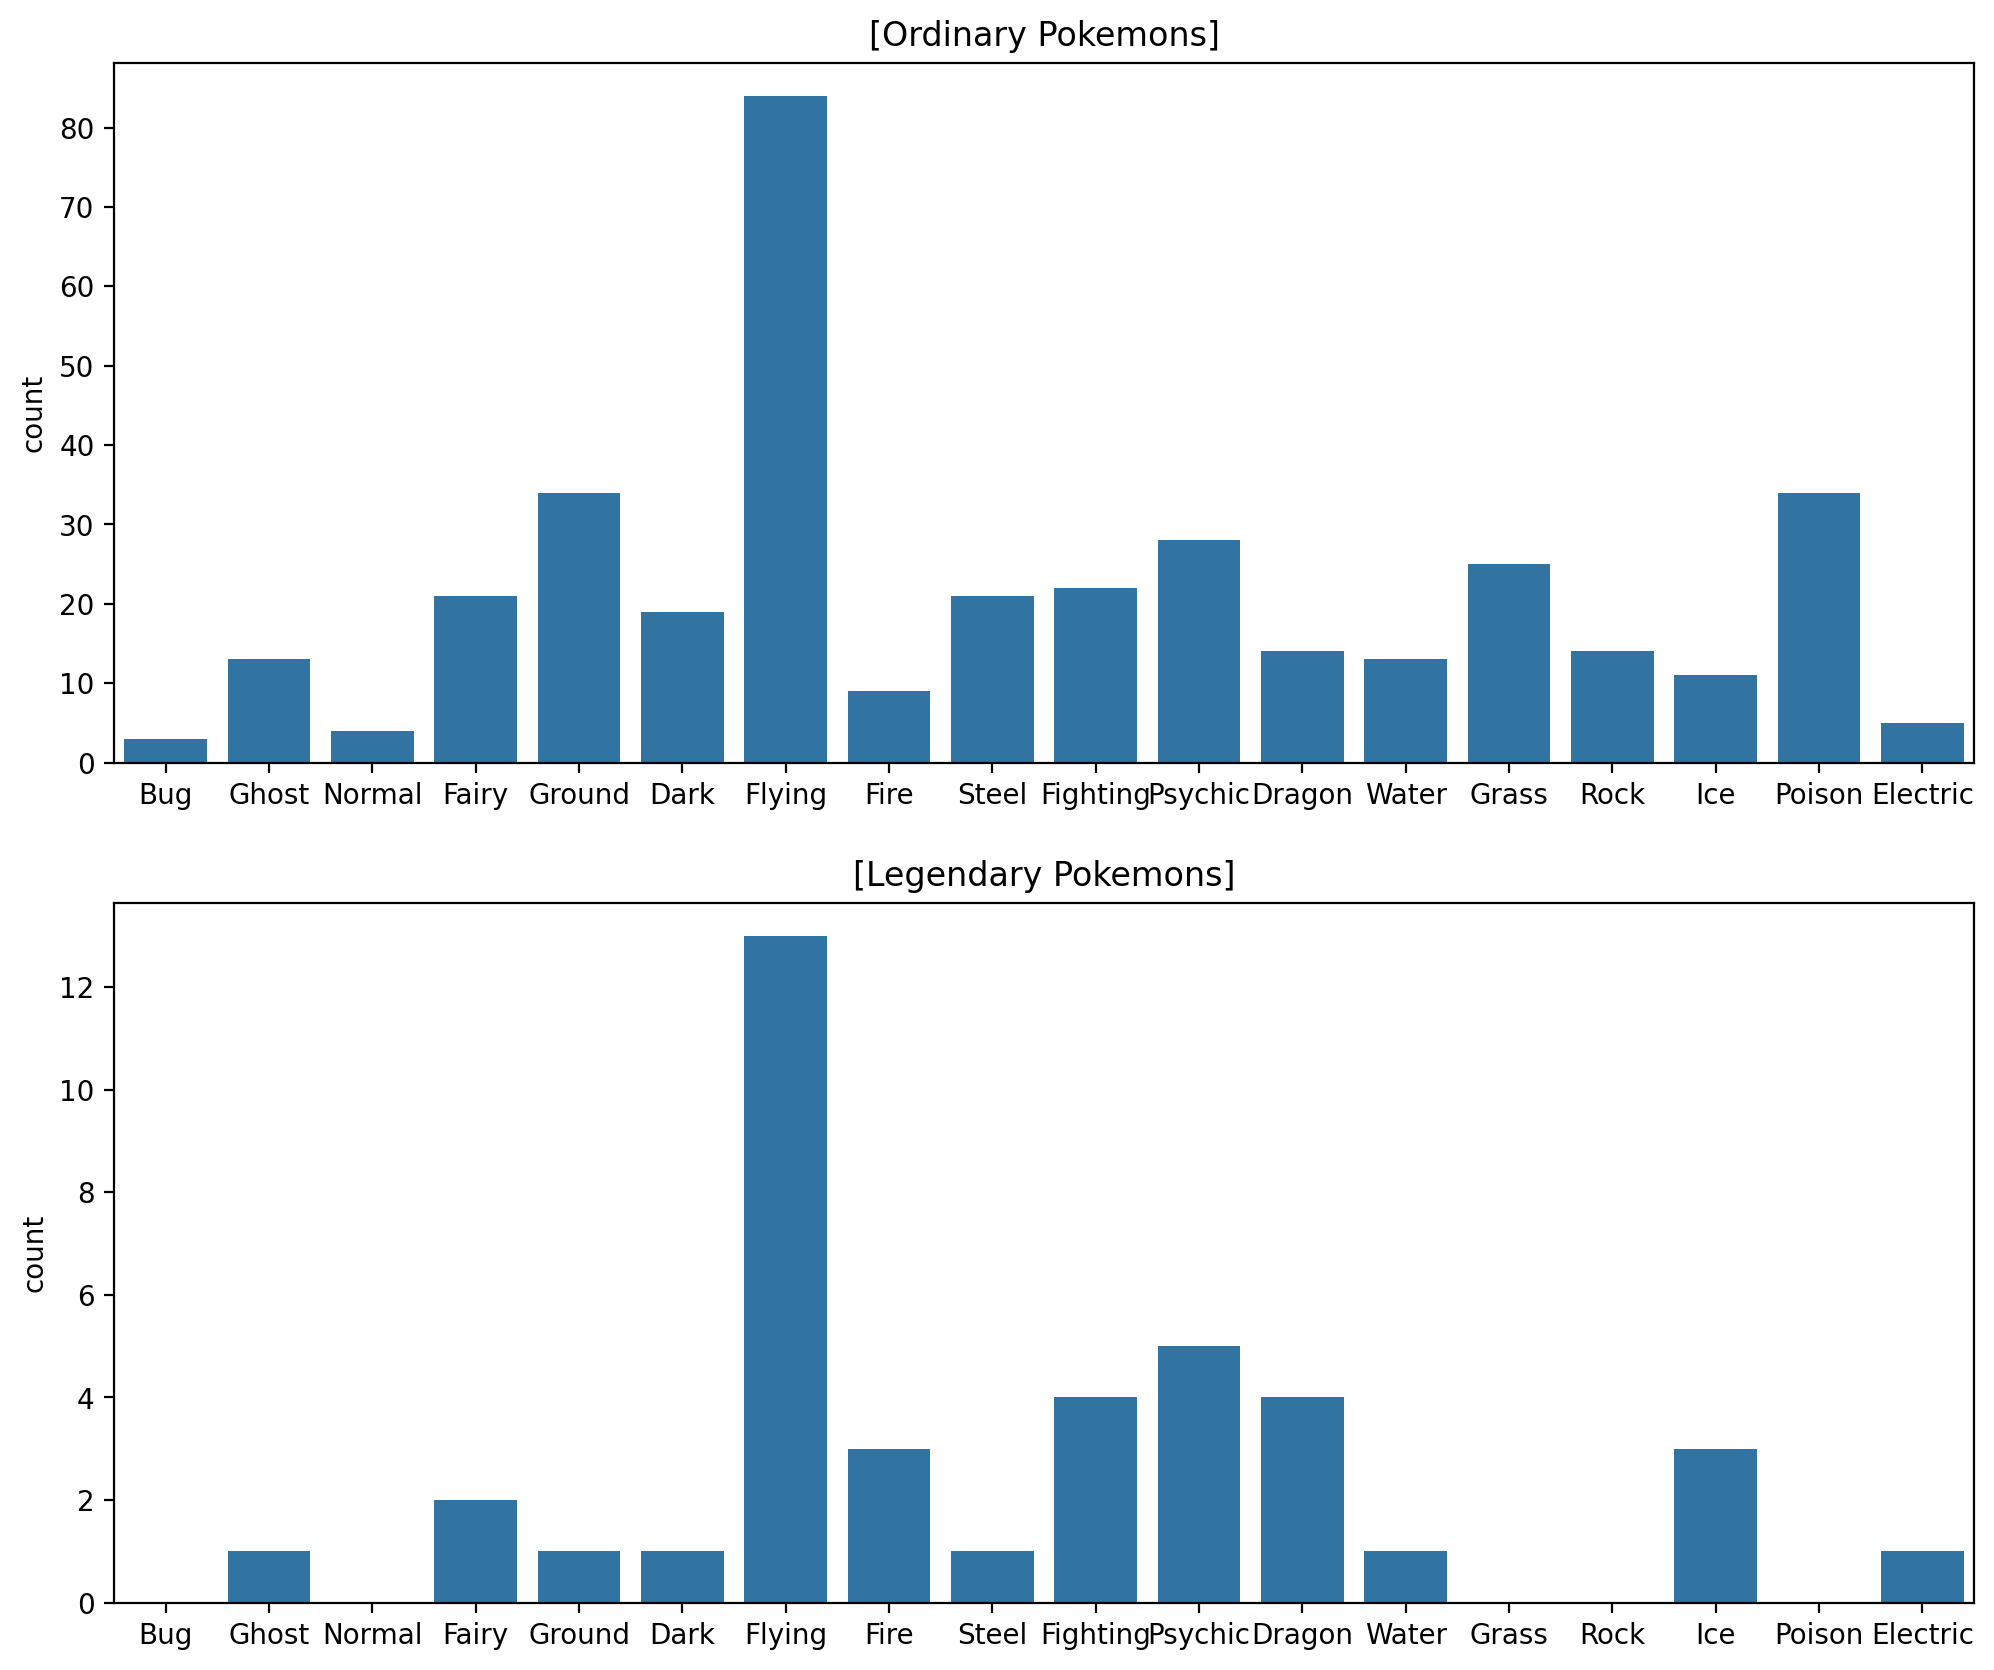

In [37]:
#2-10. 일반 포켓몬과 레전드 포켓몬의 type2 분포 알아보기
plt.figure(figsize=(12, 10))  # 화면 해상도에 따라 그래프 크기를 조정해 주세요.

plt.subplot(211)
sns.countplot(data=ordinary, x="Type 2", order=types).set_xlabel('')
plt.title("[Ordinary Pokemons]")

plt.subplot(212)
sns.countplot(data=legendary, x="Type 2", order=types).set_xlabel('')
plt.title("[Legendary Pokemons]")

plt.show()

Flying 속성의 경우 두 경우 다 가장 많다.  
일반 포켓몬에는 Grass, Rock, Poison같은 속성이 많은 반면 전설의 포켓몬은 하나도 없다.  
Type1과 마찬가지로 여전히 Dragon, Psychic과 더불어 Fighting과 같은 속성이 많다.

In [38]:
#2-10. 피벗테이블로 각 속성에 속하는 Legendary 포켓몬의 퍼센트 확인
pd.pivot_table(pokemon, index="Type 2", values="Legendary").sort_values(by=["Legendary"], ascending=False)
  #Type 2에서는 Fire속성 포켓몬의 Legendary 비율이 25%로 가장 높다

,Legendary
Type 2,
Fire,0.250000
Dragon,0.222222
Ice,0.214286
Electric,0.166667
Fighting,0.153846
Psychic,0.151515
Flying,0.134021
Fairy,0.086957
Water,0.071429


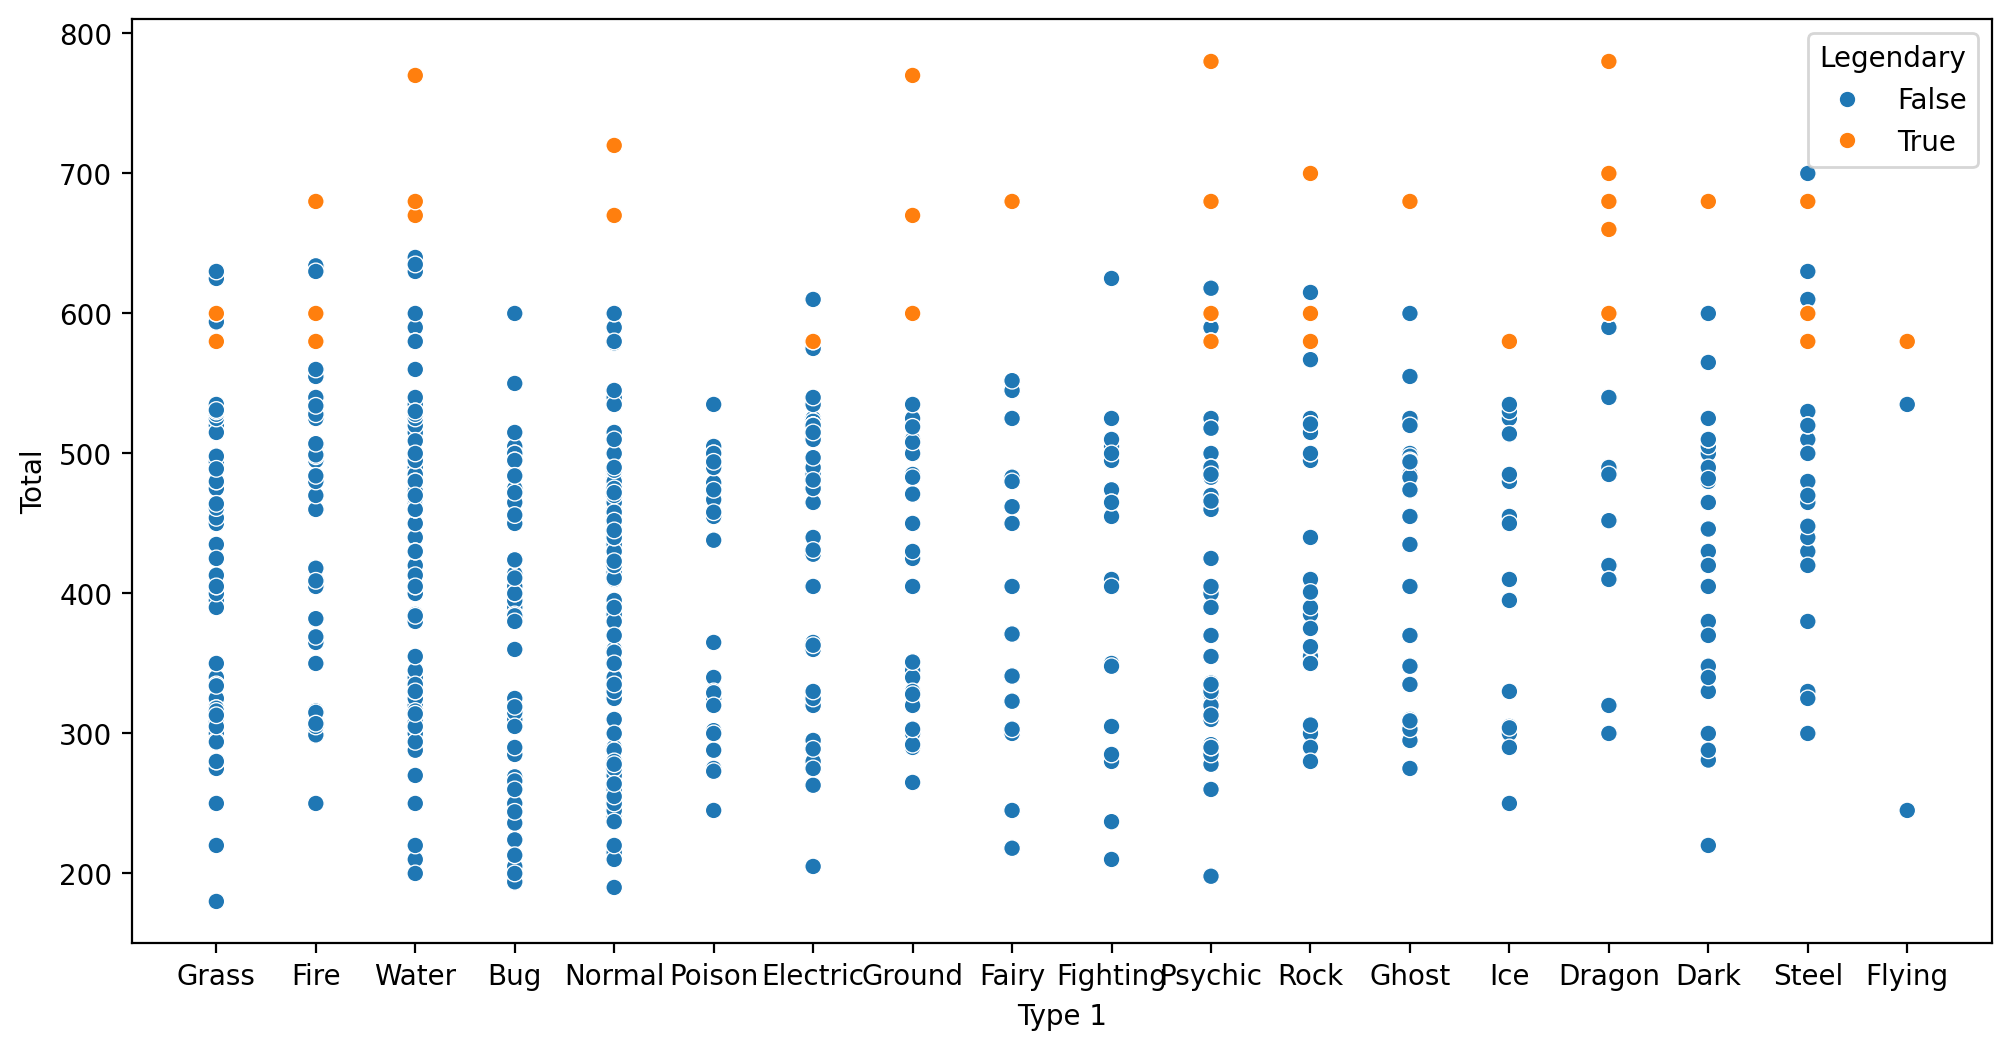

In [39]:
#2-11. stat들의 합인 Total이 Legendary와 어떤 관계가 있는지 확인하기
fig, ax = plt.subplots()
fig.set_size_inches(12, 6)  # 화면 해상도에 따라 그래프 크기를 조정해 주세요.

sns.scatterplot(data=pokemon, x="Type 1", y="Total", hue="Legendary")
plt.show()

전설의 포켓몬은 주로 Total 값이 높다는 것을 확인

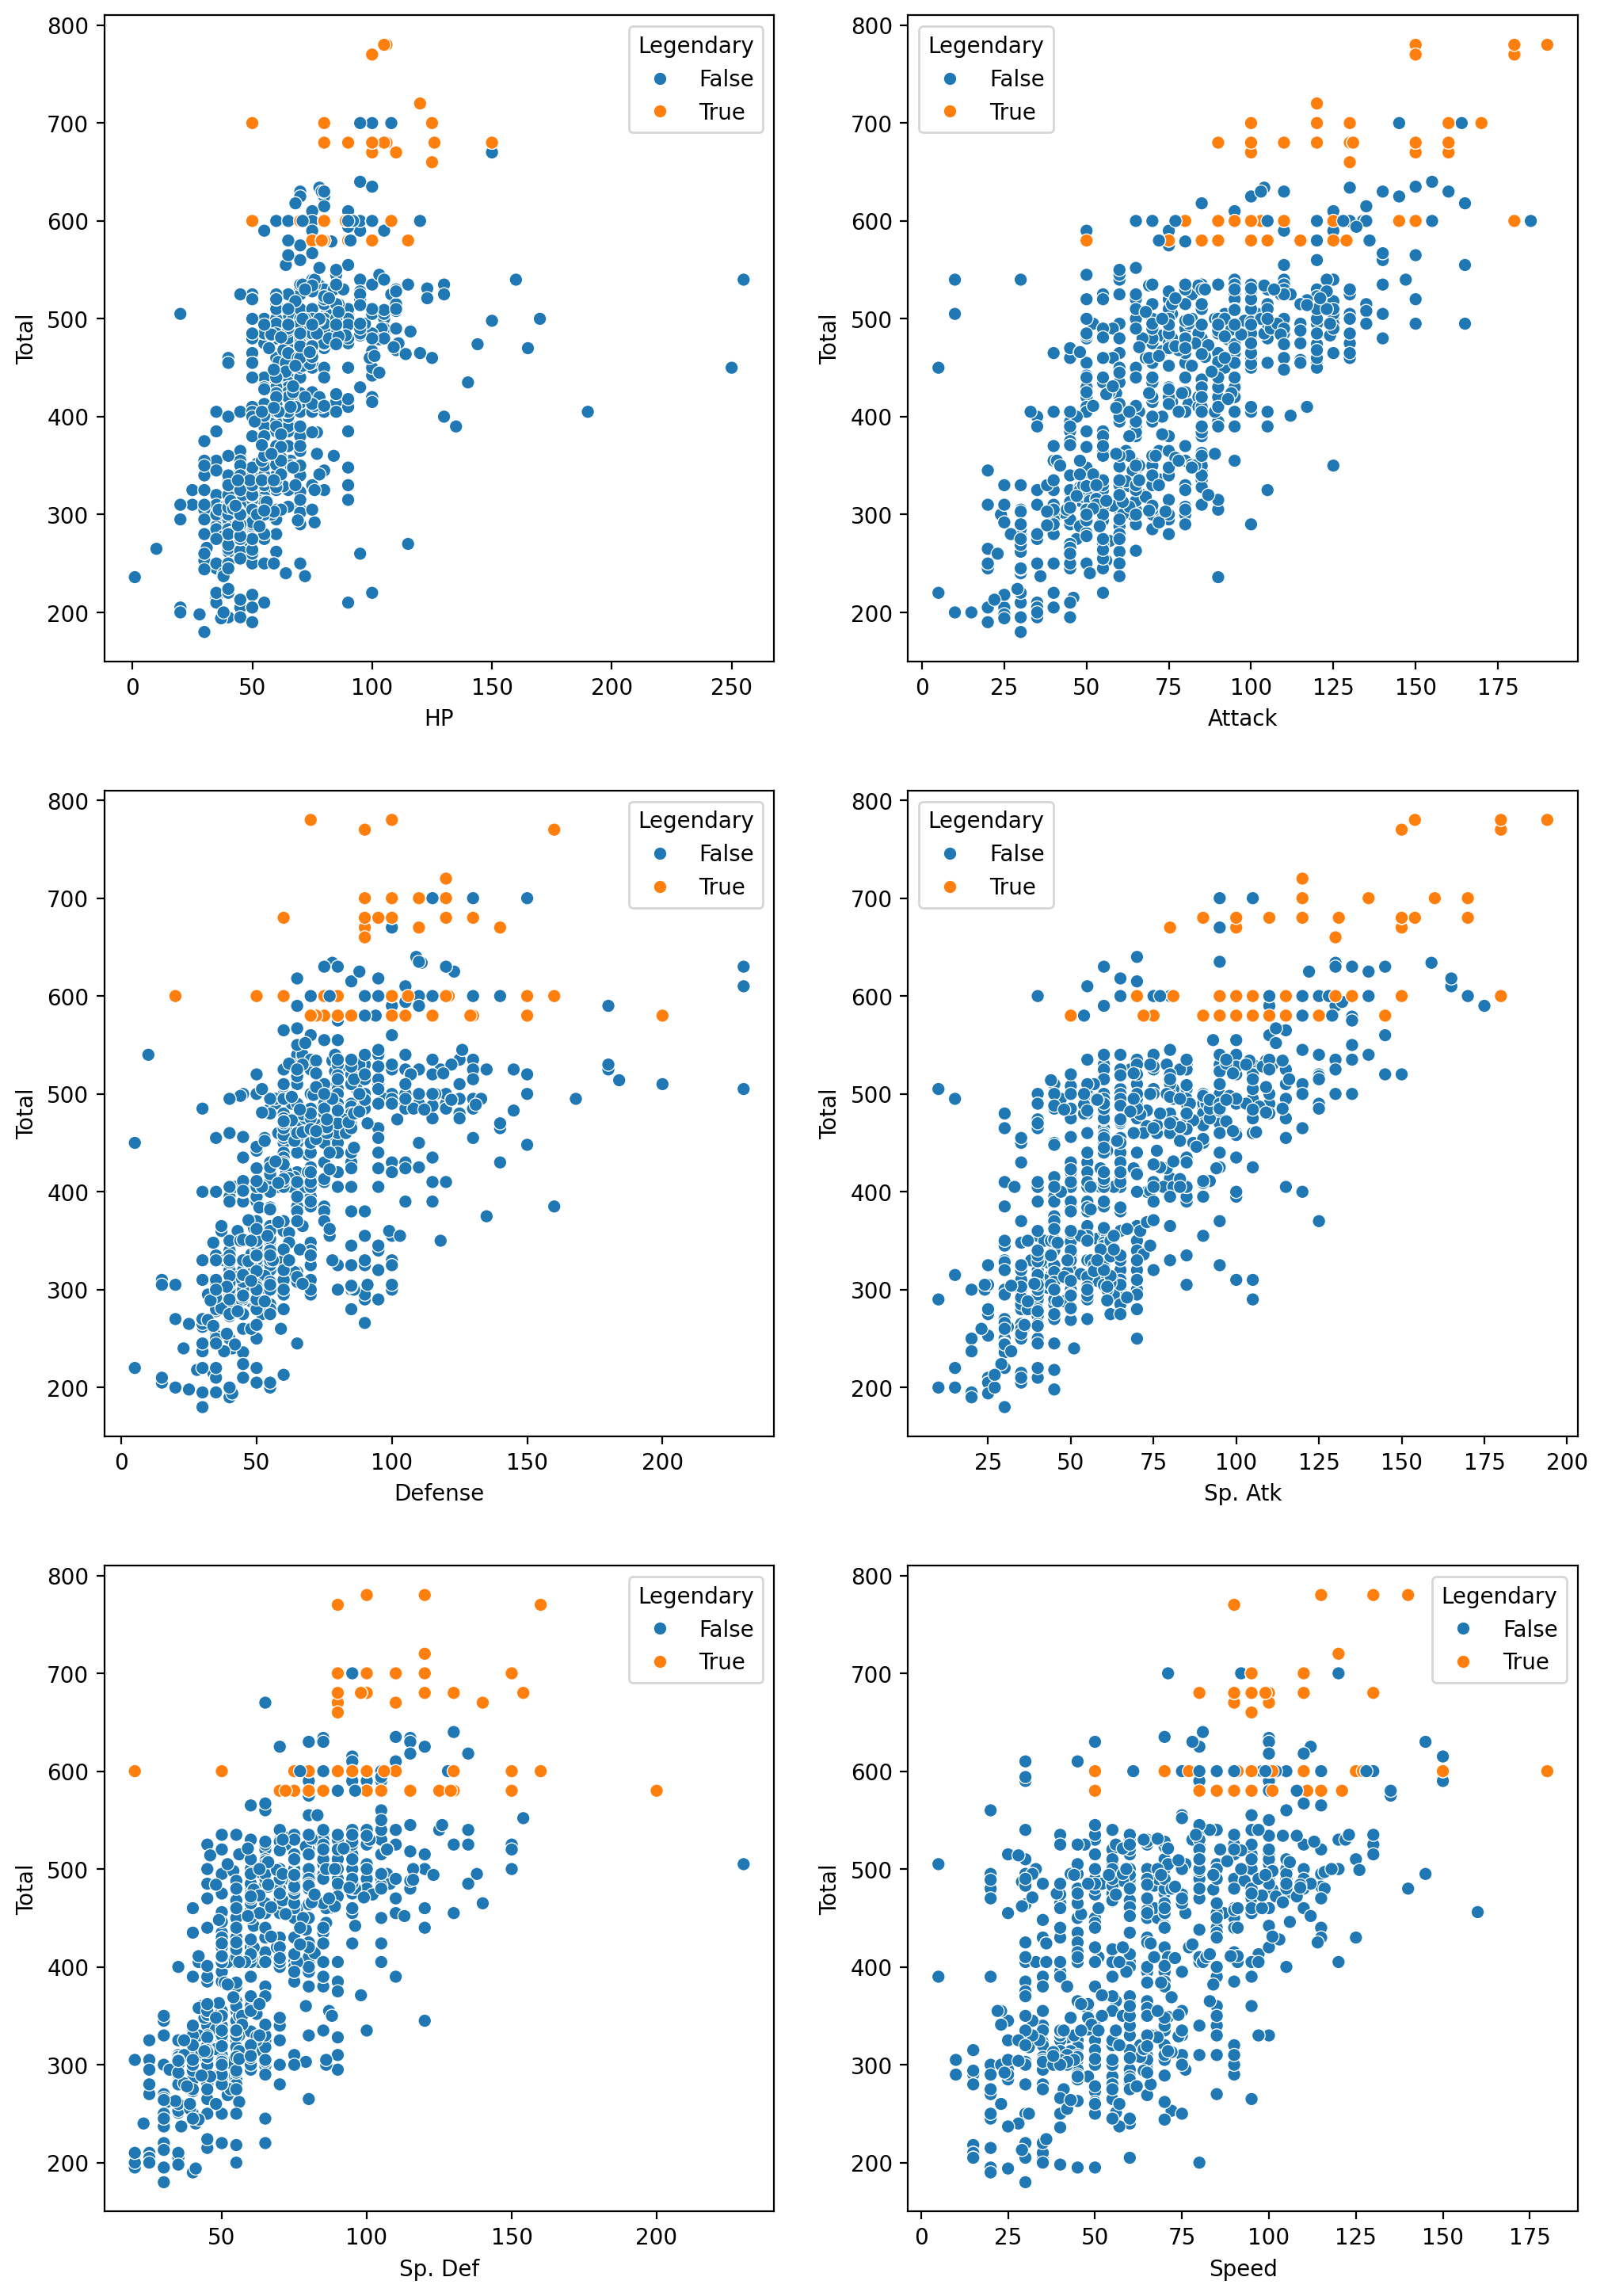

In [40]:
#2-12. 각각의 스탯 값의 분포 확인하기

figure, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(nrows=3, ncols=2)
figure.set_size_inches(12, 18)  # 화면 해상도에 따라 그래프 크기를 조정해 주세요.

# "HP" 스탯의 scatter plot
sns.scatterplot(data=pokemon, y="Total", x="HP", hue="Legendary", ax=ax1)

# "Attack" 스탯의 scatter plot
sns.scatterplot(data=pokemon, y="Total", x="Attack", hue="Legendary", ax=ax2)

# "Defense" 스탯의 scatter plot
sns.scatterplot(data=pokemon, y="Total", x="Defense", hue="Legendary", ax=ax3)

# "Sp. Atk" 스탯의 scatter plot
sns.scatterplot(data=pokemon, y="Total", x="Sp. Atk", hue="Legendary", ax=ax4)

# "Sp. Def" 스탯의 scatter plot
sns.scatterplot(data=pokemon, y="Total", x="Sp. Def", hue="Legendary", ax=ax5)

# "Speed" 스탯의 scatter plot
sns.scatterplot(data=pokemon, y="Total", x="Speed", hue="Legendary", ax=ax6)

plt.show()

Attack, Sp. Atk, Speed
이 세 가지 스탯은 Total과 거의 비례하며, 전설의 포켓몬이 각 스탯의 최대치를 차지하고 있음을 확인

### 3. 회고
이번 퀘스트를 수행하면서 데이터 분석 때부터 머신 러닝까지 학습했던 내용들이 많이 정리되었다. 노드 학습을 진행할 때도 차근차근 복기하며 진행하느라 시간이 오래 걸렸고, 레포트를 작성할 때도 코드 하나하나 직접 써보려고 하다보니 시간 안에 완성하지 못한 점이 아쉽다. 마감 시간을 지켜야 하기 때문에 미완성 상태로 제출은 하지만, 남은 부분은 수업 후 끝까지 진행할 것이다.